In [1]:
%pip install matplotlib pandas numpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 247.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 167.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 4.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 8.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 9.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 6.7 

In [43]:
import re
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
from time import sleep
from datetime import datetime
import os


def take_sample():
    """Take a sample of the UPS voltages & current load, and return a dictionary of the values.
    """

    # Execute the 'pwrstat -status' command and store the output
    output = subprocess.check_output(["sudo", "pwrstat", "-status"]).decode('utf-8').split("\n")

    # Hold the values
    vals = {}

    # Get the timestamp
    vals["timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Check each line in the output
    for line in output:
        # Get the Utility Voltage
        # If line is "Utility Voltage.............. 121 V", it picks "121"
        if re.search(r"Utility Voltage", line):
            vals["utility_voltage"] = int(re.search(r"\d+", line).group())
        # Get the Output Voltage
        # If line is "Output Voltage............... 121 V", it picks "121"
        elif re.search(r"Output Voltage", line):
            vals["output_voltage"] = int(re.search(r"\d+", line).group())
        # Get the Load
        # If line is "Load......................... 144 Watt(16 %)", it picks "144"
        elif re.search(r"Load", line):
            vals["load_wattage"] = int(re.search(r"\d+", line).group())
    return vals


def make_df(n_samples = 10, delay = 1.0):
    """create a dataframe of samples, and return the dataframe.
    
    Args:
        n_samples (int): number of samples to take. -1 means infinite, wait for keyboard interrupt.
        delay (float): delay between samples in seconds

    """
    ts0 = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    data_fpath = os.path.join(os.getcwd(), "..", "data", "ups_" + ts0 + ".csv")
    df = pd.DataFrame(columns=list(take_sample().keys()))
    try:
        i = 0
        while True:
            df.loc[i] = take_sample()
            df.to_csv("./ups.csv", index=False)
            print(f"\n({i+1}/{n_samples})\n\t{df.loc[i].to_string()}\n")
            sleep(delay)
            i += 1
            if n_samples != -1 and i >= n_samples:
                break
    except KeyboardInterrupt:
        print("Keyboard interrupt detected. Stopping the loop.")
    return df


def plot_samples(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
    axs[0].plot(df.timestamp, df.utility_voltage, linestyle='', marker='.', label="Utility Voltage", color='tab:orange')
    axs[0].plot(df.timestamp, df.output_voltage, linestyle='', marker='o', markerfacecolor='none', markeredgecolor='tab:green', label="Output Voltage", color='tab:green')
    axs[-1].plot(df.timestamp, df.load_wattage, linestyle='', marker='x', label="Load", color='tab:blue')
    for ax in axs:
        ax.legend()
    plt.show()
    return fig, axs

In [44]:
df = make_df(n_samples = -1, delay = 2.0)


(1/-1)
	timestamp          2024-01-12 18:29:04
utility_voltage                    121
output_voltage                     121
load_wattage                       162


(2/-1)
	timestamp          2024-01-12 18:29:06
utility_voltage                    121
output_voltage                     121
load_wattage                       162


(3/-1)
	timestamp          2024-01-12 18:29:08
utility_voltage                    121
output_voltage                     121
load_wattage                       180


(4/-1)
	timestamp          2024-01-12 18:29:10
utility_voltage                    121
output_voltage                     121
load_wattage                       207

Keyboard interrupt detected. Stopping the loop.


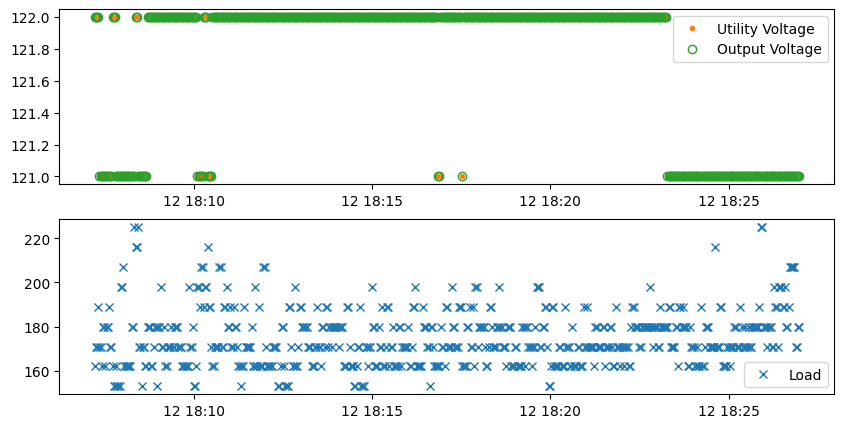

In [42]:
fig, ax = plot_samples(df)